In [5]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [6]:
import warnings
warnings.filterwarnings(action='ignore') 

import numpy as np
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.2f' % x)

# 폰트 설정 방법 2
import matplotlib as plt
import matplotlib.font_manager as fm
fm.get_fontconfig_fonts()

#font_location = r'Fonts\H2HDRM.ttf' # For Windows
#font_name = fm.FontProperties(fname=font_location).get_name()
#plt.rc('font', family=font_name)

%matplotlib inline
# 브라우저에서 바로 이미지를 그린다.

from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder

import time
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from sklearn.metrics import mean_squared_error


### 추정매출 데이터 불러오기

In [7]:
rev_2020 = pd.read_csv( r'data/서울시 우리마을가게 상권분석서비스(상권-추정매출).csv', encoding = 'cp949' )
rev_2019 = pd.read_csv( r'data/서울시 우리마을가게 상권분석서비스(상권-추정매출)_2019.csv', encoding = 'cp949' )
rev_2018 = pd.read_csv( r'data/서울시 우리마을가게 상권분석서비스(상권-추정매출)_2018.csv', encoding = 'cp949' )
rev_2017 = pd.read_csv( r'data/서울시 우리마을가게 상권분석서비스(상권-추정매출)_2017.csv', encoding = 'cp949' )
rev_2016 = pd.read_csv( r'data/서울시 우리마을가게 상권분석서비스(상권-추정매출)_2016.csv', encoding = 'cp949' )
rev_2015 = pd.read_csv( r'data/서울시 우리마을가게 상권분석서비스(상권-추정매출)_2015.csv', encoding = 'cp949' )

In [9]:
rev_2020

,기준_년_코드,기준_분기_코드,상권_구분_코드,상권_구분_코드_명,상권_코드,상권_코드_명,서비스_업종_코드,서비스_업종_코드_명,당월_매출_금액,당월_매출_건수,...,시간대_건수~24_매출_건수,남성_매출_건수,여성_매출_건수,연령대_10_매출_건수,연령대_20_매출_건수,연령대_30_매출_건수,연령대_40_매출_건수,연령대_50_매출_건수,연령대_60_이상_매출_건수,점포수
0,2020,2,U,관광특구,1001496,강남 마이스 관광특구,CS300043,전자상거래업,6415600,169,...,0,63,106,0,10,139,10,5,5,8
1,2020,2,U,관광특구,1001496,강남 마이스 관광특구,CS300032,가전제품,1853749205,8319,...,132,4331,3363,66,2146,2181,1234,1062,1003,8
2,2020,2,U,관광특구,1001496,강남 마이스 관광특구,CS300031,가구,10400909742,5270,...,35,2458,2812,0,0,245,1441,1722,1862,5
3,2020,2,U,관광특구,1001496,강남 마이스 관광특구,CS300028,화초,807257363,28506,...,580,9007,18931,232,10926,10020,3876,2101,781,6
4,2020,2,U,관광특구,1001496,강남 마이스 관광특구,CS300027,섬유제품,1410497003,41063,...,1445,8135,32928,1478,20434,8248,5427,4241,1235,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66506,2020,1,A,골목상권,1000001,계동길,CS100005,제과점,257814129,27092,...,1205,10426,14742,234,4316,7089,6188,4351,2989,4
66507,2020,1,A,골목상권,1000001,계동길,CS100004,양식음식점,156728306,3589,...,33,1281,2014,5,1361,1116,331,325,157,3
66508,2020,1,A,골목상권,1000001,계동길,CS100003,일식음식점,55484866,1272,...,241,622,508,0,134,245,275,314,162,3
66509,2020,1,A,골목상권,1000001,계동길,CS100002,중식음식점,25767161,1413,...,0,592,694,145,368,240,368,96,69,1


### 내가 관심있는 상권을 검색

In [8]:
mapo_rev_2020 = rev_2020.groupby(['상권_코드']).get_group((1001182))
mapo_rev_2019 = rev_2019.groupby(['상권_코드']).get_group((1001182))
mapo_rev_2018 = rev_2018.groupby(['상권_코드']).get_group((1001182))
mapo_rev_2017 = rev_2017.groupby(['상권_코드']).get_group((1001182))
mapo_rev_2016 = rev_2016.groupby(['상권_코드']).get_group((1001182))
mapo_rev_2015 = rev_2015.groupby(['상권_코드']).get_group((1001182))

mapo_rev_2020

,기준_년_코드,기준_분기_코드,상권_구분_코드,상권_구분_코드_명,상권_코드,상권_코드_명,서비스_업종_코드,서비스_업종_코드_명,당월_매출_금액,당월_매출_건수,...,시간대_건수~24_매출_건수,남성_매출_건수,여성_매출_건수,연령대_10_매출_건수,연령대_20_매출_건수,연령대_30_매출_건수,연령대_40_매출_건수,연령대_50_매출_건수,연령대_60_이상_매출_건수,점포수
6798,2020,2,D,발달상권,1001182,홍익대학교 주변,CS300043,전자상거래업,3261403331,72146,...,3633,18596,53359,2972,41649,15786,5285,5184,1081,69
6799,2020,2,D,발달상권,1001182,홍익대학교 주변,CS300036,조명용품,142747635,4676,...,0,2339,669,0,337,1836,335,166,335,11
6800,2020,2,D,발달상권,1001182,홍익대학교 주변,CS300035,인테리어,21189423,1579,...,367,422,1105,0,842,211,369,105,0,16
6801,2020,2,D,발달상권,1001182,홍익대학교 주변,CS300032,가전제품,14309655,5,...,0,5,0,0,0,0,0,0,5,18
6802,2020,2,D,발달상권,1001182,홍익대학교 주변,CS300031,가구,1212000000,1239,...,0,776,414,0,66,344,281,367,132,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40095,2020,1,D,발달상권,1001182,홍익대학교 주변,CS100005,제과점,2817982864,291051,...,32849,89266,200021,12916,159322,58760,29543,23064,5681,67
40096,2020,1,D,발달상권,1001182,홍익대학교 주변,CS100004,양식음식점,10575061772,403032,...,41801,151548,244118,13183,225110,86849,36033,28422,6066,208
40097,2020,1,D,발달상권,1001182,홍익대학교 주변,CS100003,일식음식점,8332608324,313259,...,42878,155441,153156,10230,176438,65077,26408,24706,5739,143
40098,2020,1,D,발달상권,1001182,홍익대학교 주변,CS100002,중식음식점,2154887595,95941,...,11182,42499,50276,4594,51097,17616,9537,8086,1843,62


### 년도와 상권코드를 입력하면 입력한 상권 및 연도의 4분기 동안 공통된 서비즈 업종을 찾는다

### ( 누락된 서비스 업종은 제외한다 )

In [9]:
def return_com_sc_by_year_and_ba(year,ba):
    if (year != 2020):
        common_sc = set(globals()["rev_{}".format(year)].groupby(['기준_년_코드','기준_분기_코드','상권_코드']).get_group((year,1,ba))['서비스_업종_코드_명'])&\
        set(globals()["rev_{}".format(year)].groupby(['기준_년_코드','기준_분기_코드','상권_코드']).get_group((year,2,ba))['서비스_업종_코드_명'])&\
        set(globals()["rev_{}".format(year)].groupby(['기준_년_코드','기준_분기_코드','상권_코드']).get_group((year,3,ba))['서비스_업종_코드_명'])&\
        set(globals()["rev_{}".format(year)].groupby(['기준_년_코드','기준_분기_코드','상권_코드']).get_group((year,4,ba))['서비스_업종_코드_명'])
    
    if (year == 2020):
        common_sc = set(globals()["rev_{}".format(year)].groupby(['기준_년_코드','기준_분기_코드','상권_코드']).get_group((year,1,ba))['서비스_업종_코드_명'])&\
        set(globals()["rev_{}".format(year)].groupby(['기준_년_코드','기준_분기_코드','상권_코드']).get_group((year,2,ba))['서비스_업종_코드_명'])
    
    return common_sc

### 그리고나서 모든 연도와 비교하여 누락된 서비스 업종을 제외한다

In [10]:
common_sc_1001182 = set(return_com_sc_by_year_and_ba(2020,1001182)) &\
set(return_com_sc_by_year_and_ba(2019,1001182)) &\
set(return_com_sc_by_year_and_ba(2018,1001182)) &\
set(return_com_sc_by_year_and_ba(2017,1001182)) &\
set(return_com_sc_by_year_and_ba(2016,1001182)) &\
set(return_com_sc_by_year_and_ba(2015,1001182))

### 최종적으로 분석에 이용할 서비스 업종의 개수를 확인한다

In [12]:
len(common_sc_1001182)

44

### 위에서 구한 common_sc(공통 서비스 업종)으로 데이터를 필터링한다

In [13]:
# new_rev_2015~2020 에 대해서 공통 sc만 남기고 합침

mapo_new_rev_2020 = mapo_rev_2020.loc[mapo_rev_2020['서비스_업종_코드_명'].isin(common_sc_1001182)]
mapo_new_rev_2019 = mapo_rev_2019.loc[mapo_rev_2019['서비스_업종_코드_명'].isin(common_sc_1001182)]
mapo_new_rev_2018 = mapo_rev_2018.loc[mapo_rev_2018['서비스_업종_코드_명'].isin(common_sc_1001182)]
mapo_new_rev_2017 = mapo_rev_2017.loc[mapo_rev_2017['서비스_업종_코드_명'].isin(common_sc_1001182)]
mapo_new_rev_2016 = mapo_rev_2016.loc[mapo_rev_2016['서비스_업종_코드_명'].isin(common_sc_1001182)]
mapo_new_rev_2015 = mapo_rev_2015.loc[mapo_rev_2015['서비스_업종_코드_명'].isin(common_sc_1001182)]

In [14]:
# print(gangnam_rev_2020.shape)
# print(gangnam_new_rev_2020.shape)
mapo_new_rev_2020

,기준_년_코드,기준_분기_코드,상권_구분_코드,상권_구분_코드_명,상권_코드,상권_코드_명,서비스_업종_코드,서비스_업종_코드_명,당월_매출_금액,당월_매출_건수,...,시간대_건수~24_매출_건수,남성_매출_건수,여성_매출_건수,연령대_10_매출_건수,연령대_20_매출_건수,연령대_30_매출_건수,연령대_40_매출_건수,연령대_50_매출_건수,연령대_60_이상_매출_건수,점포수
6798,2020,2,D,발달상권,1001182,홍익대학교 주변,CS300043,전자상거래업,3261403331,72146,...,3633,18596,53359,2972,41649,15786,5285,5184,1081,69
6800,2020,2,D,발달상권,1001182,홍익대학교 주변,CS300035,인테리어,21189423,1579,...,367,422,1105,0,842,211,369,105,0,16
6801,2020,2,D,발달상권,1001182,홍익대학교 주변,CS300032,가전제품,14309655,5,...,0,5,0,0,0,0,0,0,5,18
6803,2020,2,D,발달상권,1001182,홍익대학교 주변,CS300028,화초,777834762,29370,...,3165,13486,15359,421,13751,8786,3676,1648,565,33
6805,2020,2,D,발달상권,1001182,홍익대학교 주변,CS300024,운동/경기용품,201416735,332,...,0,232,93,0,100,74,126,25,0,27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40095,2020,1,D,발달상권,1001182,홍익대학교 주변,CS100005,제과점,2817982864,291051,...,32849,89266,200021,12916,159322,58760,29543,23064,5681,67
40096,2020,1,D,발달상권,1001182,홍익대학교 주변,CS100004,양식음식점,10575061772,403032,...,41801,151548,244118,13183,225110,86849,36033,28422,6066,208
40097,2020,1,D,발달상권,1001182,홍익대학교 주변,CS100003,일식음식점,8332608324,313259,...,42878,155441,153156,10230,176438,65077,26408,24706,5739,143
40098,2020,1,D,발달상권,1001182,홍익대학교 주변,CS100002,중식음식점,2154887595,95941,...,11182,42499,50276,4594,51097,17616,9537,8086,1843,62


### 필터링한 데이터를 합쳐서 하나의 큰 데이터로 만든다

In [75]:
mapo_all_rev = mapo_new_rev_2020.append(mapo_new_rev_2019, ignore_index=True)\
.append(mapo_new_rev_2018, ignore_index=True)\
.append(mapo_new_rev_2017, ignore_index=True)\
.append(mapo_new_rev_2016, ignore_index=True)\
.append(mapo_new_rev_2015, ignore_index=True)

mapo_all_rev

,기준_년_코드,기준_분기_코드,상권_구분_코드,상권_구분_코드_명,상권_코드,상권_코드_명,서비스_업종_코드,서비스_업종_코드_명,당월_매출_금액,당월_매출_건수,...,시간대_건수~24_매출_건수,남성_매출_건수,여성_매출_건수,연령대_10_매출_건수,연령대_20_매출_건수,연령대_30_매출_건수,연령대_40_매출_건수,연령대_50_매출_건수,연령대_60_이상_매출_건수,점포수
0,2020,2,D,발달상권,1001182,홍익대학교 주변,CS300043,전자상거래업,3261403331,72146,...,3633,18596,53359,2972,41649,15786,5285,5184,1081,69
1,2020,2,D,발달상권,1001182,홍익대학교 주변,CS300035,인테리어,21189423,1579,...,367,422,1105,0,842,211,369,105,0,16
2,2020,2,D,발달상권,1001182,홍익대학교 주변,CS300032,가전제품,14309655,5,...,0,5,0,0,0,0,0,0,5,18
3,2020,2,D,발달상권,1001182,홍익대학교 주변,CS300028,화초,777834762,29370,...,3165,13486,15359,421,13751,8786,3676,1648,565,33
4,2020,2,D,발달상권,1001182,홍익대학교 주변,CS300024,운동/경기용품,201416735,332,...,0,232,93,0,100,74,126,25,0,27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
963,2015,4,D,발달상권,1001182,홍익대학교 주변,CS200028,미용실,10950069634,179482,...,9391,95489,82854,3744,80034,55705,22305,13330,3226,165
964,2015,4,D,발달상권,1001182,홍익대학교 주변,CS200016,당구장,266556478,19927,...,6479,15214,4643,1687,12353,2933,1670,1015,199,21
965,2015,4,D,발달상권,1001182,홍익대학교 주변,CS100006,패스트푸드점,4621384109,376994,...,59924,188933,170841,22938,217234,61416,32309,22405,3492,60
966,2015,4,D,발달상권,1001182,홍익대학교 주변,CS100005,제과점,5142497778,479400,...,43131,139728,322885,20630,235143,113636,54546,30532,8132,71


### 쓸모없는 열은 제외한다.

In [76]:
mapo_all_rev = mapo_all_rev.groupby(['서비스_업종_코드']).get_group(('CS300022'))
mapo_all_rev

,기준_년_코드,기준_분기_코드,상권_구분_코드,상권_구분_코드_명,상권_코드,상권_코드_명,서비스_업종_코드,서비스_업종_코드_명,당월_매출_금액,당월_매출_건수,...,시간대_건수~24_매출_건수,남성_매출_건수,여성_매출_건수,연령대_10_매출_건수,연령대_20_매출_건수,연령대_30_매출_건수,연령대_40_매출_건수,연령대_50_매출_건수,연령대_60_이상_매출_건수,점포수
5,2020,2,D,발달상권,1001182,홍익대학교 주변,CS300022,화장품,11379527855,344826,...,39750,60062,284282,15921,210620,57299,27190,25688,7625,176
49,2020,1,D,발달상권,1001182,홍익대학교 주변,CS300022,화장품,12991505941,500153,...,75019,78386,421568,28452,314630,70071,40758,36432,9610,179
119,2019,1,D,발달상권,1001182,홍익대학교 주변,CS300022,화장품,18607834077,937507,...,151993,145043,792160,65938,571164,121666,90483,69577,18375,173
171,2019,2,D,발달상권,1001182,홍익대학교 주변,CS300022,화장품,14486991462,653925,...,108324,110985,542413,41873,386137,94268,63268,47407,20446,174
194,2019,3,D,발달상권,1001182,홍익대학교 주변,CS300022,화장품,17076223402,822553,...,137186,132702,689695,63317,475483,112997,84481,58043,28077,179
254,2019,4,D,발달상권,1001182,홍익대학교 주변,CS300022,화장품,16178154320,731871,...,130720,110555,620721,70948,420550,84286,65434,48815,41241,169
264,2018,1,D,발달상권,1001182,홍익대학교 주변,CS300022,화장품,20582708008,1123570,...,191147,155315,960840,109526,721000,127696,81210,63313,13417,188
339,2018,2,D,발달상권,1001182,홍익대학교 주변,CS300022,화장품,19366102563,1015991,...,185781,147047,860911,84217,633519,132839,82208,59597,15583,183
371,2018,3,D,발달상권,1001182,홍익대학교 주변,CS300022,화장품,18201391328,997719,...,187174,149219,840827,89867,617679,123080,85591,60626,13209,181
409,2018,4,D,발달상권,1001182,홍익대학교 주변,CS300022,화장품,23243161708,1227329,...,219037,227556,989817,110042,742197,168766,100806,76456,19120,181


In [77]:
mapo_all_rev = mapo_all_rev.drop(['상권_구분_코드','상권_구분_코드_명','상권_코드',
                                  '상권_코드_명','서비스_업종_코드_명'], axis=1)
mapo_all_rev

,기준_년_코드,기준_분기_코드,서비스_업종_코드,당월_매출_금액,당월_매출_건수,주중_매출_비율,주말_매출_비율,월요일_매출_비율,화요일_매출_비율,수요일_매출_비율,...,시간대_건수~24_매출_건수,남성_매출_건수,여성_매출_건수,연령대_10_매출_건수,연령대_20_매출_건수,연령대_30_매출_건수,연령대_40_매출_건수,연령대_50_매출_건수,연령대_60_이상_매출_건수,점포수
5,2020,2,CS300022,11379527855,344826,67,33,12,12,13,...,39750,60062,284282,15921,210620,57299,27190,25688,7625,176
49,2020,1,CS300022,12991505941,500153,69,31,12,13,14,...,75019,78386,421568,28452,314630,70071,40758,36432,9610,179
119,2019,1,CS300022,18607834077,937507,67,33,10,14,13,...,151993,145043,792160,65938,571164,121666,90483,69577,18375,173
171,2019,2,CS300022,14486991462,653925,67,33,12,12,13,...,108324,110985,542413,41873,386137,94268,63268,47407,20446,174
194,2019,3,CS300022,17076223402,822553,68,32,15,12,13,...,137186,132702,689695,63317,475483,112997,84481,58043,28077,179
254,2019,4,CS300022,16178154320,731871,68,32,11,16,13,...,130720,110555,620721,70948,420550,84286,65434,48815,41241,169
264,2018,1,CS300022,20582708008,1123570,66,34,13,13,13,...,191147,155315,960840,109526,721000,127696,81210,63313,13417,188
339,2018,2,CS300022,19366102563,1015991,65,35,11,12,12,...,185781,147047,860911,84217,633519,132839,82208,59597,15583,183
371,2018,3,CS300022,18201391328,997719,67,33,12,12,14,...,187174,149219,840827,89867,617679,123080,85591,60626,13209,181
409,2018,4,CS300022,23243161708,1227329,67,33,14,11,13,...,219037,227556,989817,110042,742197,168766,100806,76456,19120,181


In [36]:
# mapo_all_rev.to_csv(r'mapo_all_rev.csv', encoding = 'cp949')
# 다운로드해서 제대로 됐는지 확인

### 위 과정에서 인풋 데이터 준비는 1차적으로 끝났고, 이제 아웃풋 데이터를 준비한다

In [94]:
fr_2020 = pd.read_csv( r'data/서울시 우리마을가게 상권분석서비스(상권-점포)_2020_new.csv', encoding = 'cp949' )
fr_2019 = pd.read_csv( r'data/서울시 우리마을가게 상권분석서비스(상권-점포)_2019_new.csv', encoding = 'cp949' )
fr_2018 = pd.read_csv( r'data/서울시 우리마을가게 상권분석서비스(상권-점포)_2018_new.csv', encoding = 'cp949' )
fr_2017 = pd.read_csv( r'data/서울시 우리마을가게 상권분석서비스(상권-점포)_2017_new.csv', encoding = 'cp949' )
fr_2016 = pd.read_csv( r'data/서울시 우리마을가게 상권분석서비스(상권-점포)_2016_new.csv', encoding = 'cp949' )
fr_2015 = pd.read_csv( r'data/서울시 우리마을가게 상권분석서비스(상권-점포)_2015_new.csv', encoding = 'cp949' )

In [95]:
fr_2020

,Unnamed: 0,기준_년_코드,기준_분기_코드,상권_구분_코드,상권_구분_코드_명,상권_코드,상권_코드_명,서비스_업종_코드,서비스_업종_코드_명,폐업_률
0,0,2020,2,U,관광특구,1001496,강남 마이스 관광특구,CS300043,전자상거래업,0
1,1,2020,2,U,관광특구,1001496,강남 마이스 관광특구,CS300042,주유소,0
2,2,2020,2,U,관광특구,1001496,강남 마이스 관광특구,CS300041,예술품,0
3,3,2020,2,U,관광특구,1001496,강남 마이스 관광특구,CS300040,재생용품 판매점,0
4,4,2020,2,U,관광특구,1001496,강남 마이스 관광특구,CS300038,자동차부품,0
...,...,...,...,...,...,...,...,...,...,...
184550,184550,2020,1,A,골목상권,1000001,계동길,CS100005,제과점,0
184551,184551,2020,1,A,골목상권,1000001,계동길,CS100004,양식음식점,0
184552,184552,2020,1,A,골목상권,1000001,계동길,CS100003,일식음식점,0
184553,184553,2020,1,A,골목상권,1000001,계동길,CS100002,중식음식점,0


In [96]:
mapo_fr_2020 = fr_2020.groupby(['상권_코드']).get_group((1001182))
mapo_fr_2019 = fr_2019.groupby(['상권_코드']).get_group((1001182))
mapo_fr_2018 = fr_2018.groupby(['상권_코드']).get_group((1001182))
mapo_fr_2017 = fr_2017.groupby(['상권_코드']).get_group((1001182))
mapo_fr_2016 = fr_2016.groupby(['상권_코드']).get_group((1001182))
mapo_fr_2015 = fr_2015.groupby(['상권_코드']).get_group((1001182))

mapo_fr_2020

,Unnamed: 0,기준_년_코드,기준_분기_코드,상권_구분_코드,상권_구분_코드_명,상권_코드,상권_코드_명,서비스_업종_코드,서비스_업종_코드_명,폐업_률
16815,16815,2020,2,D,발달상권,1001182,홍익대학교 주변,CS300043,전자상거래업,0
16816,16816,2020,2,D,발달상권,1001182,홍익대학교 주변,CS300041,예술품,0
16817,16817,2020,2,D,발달상권,1001182,홍익대학교 주변,CS300040,재생용품 판매점,0
16818,16818,2020,2,D,발달상권,1001182,홍익대학교 주변,CS300038,자동차부품,0
16819,16819,2020,2,D,발달상권,1001182,홍익대학교 주변,CS300037,중고차판매,0
...,...,...,...,...,...,...,...,...,...,...
109283,109283,2020,1,D,발달상권,1001182,홍익대학교 주변,CS100005,제과점,8
109284,109284,2020,1,D,발달상권,1001182,홍익대학교 주변,CS100004,양식음식점,4
109285,109285,2020,1,D,발달상권,1001182,홍익대학교 주변,CS100003,일식음식점,6
109286,109286,2020,1,D,발달상권,1001182,홍익대학교 주변,CS100002,중식음식점,3


In [97]:
mapo_fr_2020 = mapo_fr_2020.groupby(['서비스_업종_코드']).get_group('CS300022')
mapo_fr_2019 = mapo_fr_2019.groupby(['서비스_업종_코드']).get_group('CS300022')
mapo_fr_2018 = mapo_fr_2018.groupby(['서비스_업종_코드']).get_group('CS300022')
mapo_fr_2017 = mapo_fr_2017.groupby(['서비스_업종_코드']).get_group('CS300022')
mapo_fr_2016 = mapo_fr_2016.groupby(['서비스_업종_코드']).get_group('CS300022')
mapo_fr_2015 = mapo_fr_2015.groupby(['서비스_업종_코드']).get_group('CS300022')

mapo_fr_2020

,Unnamed: 0,기준_년_코드,기준_분기_코드,상권_구분_코드,상권_구분_코드_명,상권_코드,상권_코드_명,서비스_업종_코드,서비스_업종_코드_명,폐업_률
16833,16833,2020,2,D,발달상권,1001182,홍익대학교 주변,CS300022,화장품,2
109209,109209,2020,1,D,발달상권,1001182,홍익대학교 주변,CS300022,화장품,6


In [98]:
mapo_new_fr= mapo_fr_2020.append(mapo_fr_2019, ignore_index=True)\
.append(mapo_fr_2018, ignore_index=True)\
.append(mapo_fr_2017, ignore_index=True)\
.append(mapo_fr_2016, ignore_index=True)\
.append(mapo_fr_2015, ignore_index=True)

mapo_new_fr

,Unnamed: 0,기준_년_코드,기준_분기_코드,상권_구분_코드,상권_구분_코드_명,상권_코드,상권_코드_명,서비스_업종_코드,서비스_업종_코드_명,폐업_률
0,16833,2020,2,D,발달상권,1001182,홍익대학교 주변,CS300022,화장품,2
1,109209,2020,1,D,발달상권,1001182,홍익대학교 주변,CS300022,화장품,6
2,15,2019,1,D,발달상권,1001182,홍익대학교 주변,CS300022,화장품,8
3,136730,2019,2,D,발달상권,1001182,홍익대학교 주변,CS300022,화장품,2
4,201855,2019,3,D,발달상권,1001182,홍익대학교 주변,CS300022,화장품,3
5,294173,2019,4,D,발달상권,1001182,홍익대학교 주변,CS300022,화장품,4
6,28261,2018,1,D,발달상권,1001182,홍익대학교 주변,CS300022,화장품,3
7,90439,2018,2,D,발달상권,1001182,홍익대학교 주변,CS300022,화장품,6
8,265441,2018,3,D,발달상권,1001182,홍익대학교 주변,CS300022,화장품,3
9,310693,2018,4,D,발달상권,1001182,홍익대학교 주변,CS300022,화장품,3


In [99]:
mapo_new_fr=mapo_new_fr.drop(['Unnamed: 0','기준_년_코드','기준_분기_코드','상권_구분_코드','상권_구분_코드_명','상권_코드',
                                  '상권_코드_명','서비스_업종_코드','서비스_업종_코드_명'], axis=1)
mapo_new_fr

,폐업_률
0,2
1,6
2,8
3,2
4,3
5,4
6,3
7,6
8,3
9,3


### 인풋 데이터의 서비스업종과 아웃풋 데이터를 합친다.

### 이때, df의 인덱스가 서로 달라서 합치는데 문제가 되니, 인덱스를 초기화 한다

In [100]:
mapo_all_rev = mapo_all_rev.reset_index(drop=True, inplace=False)
mapo_new_fr = mapo_new_fr.reset_index(drop=True, inplace=False)

mapo = pd.concat( [mapo_all_rev, mapo_new_fr],axis=1) 
mapo

,기준_년_코드,기준_분기_코드,서비스_업종_코드,당월_매출_금액,당월_매출_건수,주중_매출_비율,주말_매출_비율,월요일_매출_비율,화요일_매출_비율,수요일_매출_비율,...,남성_매출_건수,여성_매출_건수,연령대_10_매출_건수,연령대_20_매출_건수,연령대_30_매출_건수,연령대_40_매출_건수,연령대_50_매출_건수,연령대_60_이상_매출_건수,점포수,폐업_률
0,2020,2,CS300022,11379527855,344826,67,33,12,12,13,...,60062,284282,15921,210620,57299,27190,25688,7625,176,2
1,2020,1,CS300022,12991505941,500153,69,31,12,13,14,...,78386,421568,28452,314630,70071,40758,36432,9610,179,6
2,2019,1,CS300022,18607834077,937507,67,33,10,14,13,...,145043,792160,65938,571164,121666,90483,69577,18375,173,8
3,2019,2,CS300022,14486991462,653925,67,33,12,12,13,...,110985,542413,41873,386137,94268,63268,47407,20446,174,2
4,2019,3,CS300022,17076223402,822553,68,32,15,12,13,...,132702,689695,63317,475483,112997,84481,58043,28077,179,3
5,2019,4,CS300022,16178154320,731871,68,32,11,16,13,...,110555,620721,70948,420550,84286,65434,48815,41241,169,4
6,2018,1,CS300022,20582708008,1123570,66,34,13,13,13,...,155315,960840,109526,721000,127696,81210,63313,13417,188,3
7,2018,2,CS300022,19366102563,1015991,65,35,11,12,12,...,147047,860911,84217,633519,132839,82208,59597,15583,183,6
8,2018,3,CS300022,18201391328,997719,67,33,12,12,14,...,149219,840827,89867,617679,123080,85591,60626,13209,181,3
9,2018,4,CS300022,23243161708,1227329,67,33,14,11,13,...,227556,989817,110042,742197,168766,100806,76456,19120,181,3


In [101]:
mapo_col=mapo.columns
mapo_col

Index(['기준_년_코드', '기준_분기_코드', '서비스_업종_코드', '당월_매출_금액', '당월_매출_건수', '주중_매출_비율',
       '주말_매출_비율', '월요일_매출_비율', '화요일_매출_비율', '수요일_매출_비율', '목요일_매출_비율',
       '금요일_매출_비율', '토요일_매출_비율', '일요일_매출_비율', '시간대_00~06_매출_비율',
       '시간대_06~11_매출_비율', '시간대_11~14_매출_비율', '시간대_14~17_매출_비율',
       '시간대_17~21_매출_비율', '시간대_21~24_매출_비율', '남성_매출_비율', '여성_매출_비율',
       '연령대_10_매출_비율', '연령대_20_매출_비율', '연령대_30_매출_비율', '연령대_40_매출_비율',
       '연령대_50_매출_비율', '연령대_60_이상_매출_비율', '주중_매출_금액', '주말_매출_금액', '월요일_매출_금액',
       '화요일_매출_금액', '수요일_매출_금액', '목요일_매출_금액', '금요일_매출_금액', '토요일_매출_금액',
       '일요일_매출_금액', '시간대_00~06_매출_금액', '시간대_06~11_매출_금액', '시간대_11~14_매출_금액',
       '시간대_14~17_매출_금액', '시간대_17~21_매출_금액', '시간대_21~24_매출_금액', '남성_매출_금액',
       '여성_매출_금액', '연령대_10_매출_금액', '연령대_20_매출_금액', '연령대_30_매출_금액',
       '연령대_40_매출_금액', '연령대_50_매출_금액', '연령대_60_이상_매출_금액', '주중_매출_건수',
       '주말_매출_건수', '월요일_매출_건수', '화요일_매출_건수', '수요일_매출_건수', '목요일_매출_건수',
       '금요일_매출_건수', '토요일_매출_건수', '일요일_매출_건수', '시간대_건수~06_매출_건수',
    

In [102]:
len(mapo_col)

76

In [115]:
from sklearn import preprocessing
for i in range(3,75):
    x = mapo[mapo_col[i]].values #returns a numpy array
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(pd.DataFrame(x))
    
    # min_Max 적용
    mapo[mapo_col[i]] = pd.DataFrame(x_scaled)

In [116]:
all_data_in = mapo.drop(['폐업_률'], axis=1)
all_data_in

,기준_년_코드,기준_분기_코드,서비스_업종_코드,당월_매출_금액,당월_매출_건수,주중_매출_비율,주말_매출_비율,월요일_매출_비율,화요일_매출_비율,수요일_매출_비율,...,시간대_건수~24_매출_건수,남성_매출_건수,여성_매출_건수,연령대_10_매출_건수,연령대_20_매출_건수,연령대_30_매출_건수,연령대_40_매출_건수,연령대_50_매출_건수,연령대_60_이상_매출_건수,점포수
0,2020,2,CS300022,0.00,0.00,0.33,0.67,0.40,0.20,0.50,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.17
1,2020,1,CS300022,0.10,0.14,0.67,0.33,0.40,0.40,0.75,...,0.16,0.11,0.15,0.10,0.15,0.10,0.17,0.21,0.06,0.24
2,2019,1,CS300022,0.44,0.55,0.33,0.67,0.00,0.60,0.50,...,0.50,0.51,0.54,0.41,0.51,0.48,0.81,0.84,0.32,0.10
3,2019,2,CS300022,0.19,0.28,0.33,0.67,0.40,0.20,0.50,...,0.30,0.30,0.28,0.21,0.25,0.28,0.46,0.42,0.38,0.12
4,2019,3,CS300022,0.34,0.44,0.50,0.50,1.00,0.20,0.50,...,0.43,0.43,0.43,0.39,0.37,0.42,0.73,0.62,0.61,0.24
5,2019,4,CS300022,0.29,0.36,0.50,0.50,0.20,1.00,0.50,...,0.40,0.30,0.36,0.45,0.30,0.20,0.49,0.44,1.00,0.00
6,2018,1,CS300022,0.56,0.72,0.17,0.83,0.60,0.40,0.50,...,0.67,0.57,0.72,0.76,0.72,0.53,0.69,0.72,0.17,0.45
7,2018,2,CS300022,0.48,0.62,0.00,1.00,0.20,0.20,0.25,...,0.65,0.52,0.61,0.56,0.60,0.57,0.70,0.65,0.24,0.33
8,2018,3,CS300022,0.41,0.60,0.33,0.67,0.40,0.20,0.75,...,0.65,0.53,0.59,0.60,0.57,0.49,0.75,0.67,0.17,0.29
9,2018,4,CS300022,0.72,0.81,0.33,0.67,0.80,0.00,0.50,...,0.80,1.00,0.75,0.77,0.75,0.84,0.94,0.97,0.34,0.29


### 시계열 인풋데이터 만들기

In [136]:
def four_season_data_in(all_data_in,y_1,q_1,y_2,q_2,y_3,q_3,y_4,q_4):

    _test = pd.merge(all_data_in.groupby(['기준_년_코드','기준_분기_코드']).get_group((y_1,q_1)).drop(['기준_년_코드','기준_분기_코드'], axis=1),
                     all_data_in.groupby(['기준_년_코드','기준_분기_코드']).get_group((y_2,q_2)).drop(['기준_년_코드','기준_분기_코드'], axis=1), how='left',on=['서비스_업종_코드'],suffixes=('-4', '-3'))
    _test = pd.merge(_test,all_data_in.groupby(['기준_년_코드','기준_분기_코드']).get_group((y_3,q_3)).drop(['기준_년_코드','기준_분기_코드'], axis=1), how='left',on=['서비스_업종_코드'],suffixes=('', '-2'))
    _test = pd.merge(_test,all_data_in.groupby(['기준_년_코드','기준_분기_코드']).get_group((y_4,q_4)).drop(['기준_년_코드','기준_분기_코드'], axis=1), how='left',on=['서비스_업종_코드'],suffixes=('', '-1'))
    return _test

In [137]:
x_predict_2020_2 = four_season_data_in(all_data_in,2019,2,2019,3,2019,4,2020,1)
x_predict_2020_2

,서비스_업종_코드,당월_매출_금액-4,당월_매출_건수-4,주중_매출_비율-4,주말_매출_비율-4,월요일_매출_비율-4,화요일_매출_비율-4,수요일_매출_비율-4,목요일_매출_비율-4,금요일_매출_비율-4,...,시간대_건수~24_매출_건수-1,남성_매출_건수-1,여성_매출_건수-1,연령대_10_매출_건수-1,연령대_20_매출_건수-1,연령대_30_매출_건수-1,연령대_40_매출_건수-1,연령대_50_매출_건수-1,연령대_60_이상_매출_건수-1,점포수-1
0,CS300022,0.19,0.28,0.33,0.67,0.40,0.20,0.50,0.00,0.40,...,0.16,0.11,0.15,0.10,0.15,0.10,0.17,0.21,0.06,0.24


### 시계열 아웃풋 데이터 만들기

In [138]:
def four_season_data_out(all_data_c,y_5,q_5):
    
    _test = pd.DataFrame(all_data_c.groupby(['기준_년_코드','기준_분기_코드']).get_group((y_5,q_5))['폐업_률'])
    
    return _test

In [139]:
y_predict_2020_2 = four_season_data_out(mapo,2020,2)
y_predict_2020_2

,폐업_률
0,2


### 시계열 데이터 합치기 

In [140]:
list_season = []
for i in range(2015,2020):
    
    for j in range(1,5):
        _list = []
        _list.append(i)
        _list.append(j)
        list_season.append(_list)
        
for i in range(2020,2021):
    
    for j in range(1,3):
        _list = []
        _list.append(i)
        _list.append(j)
        list_season.append(_list)        

print(list_season)

[[2015, 1], [2015, 2], [2015, 3], [2015, 4], [2016, 1], [2016, 2], [2016, 3], [2016, 4], [2017, 1], [2017, 2], [2017, 3], [2017, 4], [2018, 1], [2018, 2], [2018, 3], [2018, 4], [2019, 1], [2019, 2], [2019, 3], [2019, 4], [2020, 1], [2020, 2]]


In [141]:
for i in range(0,18):
    # print(i)
    globals()["x_predict_{}_{}".format(list_season[i+4][0], list_season[i+4][1])] = four_season_data_in(all_data_in,
                                                                                                                  list_season[i][0],list_season[i][1],
                                                                                                                  list_season[i+1][0],list_season[i+1][1],
                                                                                                                  list_season[i+2][0],list_season[i+2][1],
                                                                                                                  list_season[i+3][0],list_season[i+3][1]
                                                                                                              )
    globals()["y_predict_{}_{}".format(list_season[i+4][0], list_season[i+4][1])] = four_season_data_out(mapo,
                                                                                                                 list_season[i+4][0],list_season[i+4][1])
    #x_predict_2020_2_강남구 = four_season_data_in(all_data_in,'강남구',2019,2,2019,3,2019,4,2020,1)
    #y_predict_2020_2_강남구 = four_season_data_out(all_data_c,'강남구',2020,2)

In [166]:
# df 를 vertically concat 하기 위해 append 함
x_in = pd.DataFrame(columns=x_predict_2020_2.columns)
x_out = pd.DataFrame(columns=y_predict_2020_2.columns)
for i in range(0,18):
    x_in = x_in.append(globals()["x_predict_{}_{}".format(list_season[i+4][0], list_season[i+4][1])], ignore_index=False)
    x_out = x_out.append(globals()["y_predict_{}_{}".format(list_season[i+4][0], list_season[i+4][1])], ignore_index=False)
x_in=x_in.drop(['서비스_업종_코드'], axis=1)
x_in = x_in.reset_index(drop=True, inplace=False)
x_in

,당월_매출_금액-4,당월_매출_건수-4,주중_매출_비율-4,주말_매출_비율-4,월요일_매출_비율-4,화요일_매출_비율-4,수요일_매출_비율-4,목요일_매출_비율-4,금요일_매출_비율-4,토요일_매출_비율-4,...,시간대_건수~24_매출_건수-1,남성_매출_건수-1,여성_매출_건수-1,연령대_10_매출_건수-1,연령대_20_매출_건수-1,연령대_30_매출_건수-1,연령대_40_매출_건수-1,연령대_50_매출_건수-1,연령대_60_이상_매출_건수-1,점포수-1
0,0.48,0.50,0.33,0.67,0.60,0.40,0.00,0.00,0.60,0.80,...,0.68,0.54,0.63,0.61,0.60,0.68,0.73,0.59,0.10,0.90
1,0.56,0.54,0.83,0.17,0.60,0.40,0.75,0.00,0.80,0.40,...,0.91,0.76,0.96,0.84,0.94,0.96,0.92,0.94,0.12,0.90
2,0.61,0.60,1.00,0.00,0.40,0.40,1.00,0.25,0.40,0.20,...,0.95,0.74,0.93,0.74,0.91,1.00,0.92,0.90,0.14,1.00
3,0.66,0.64,0.67,0.33,0.20,0.60,0.00,1.00,0.40,0.60,...,1.00,0.77,0.98,0.92,0.97,0.87,1.00,0.92,0.15,0.79
4,0.93,0.97,0.00,1.00,0.00,0.20,0.25,0.00,0.40,1.00,...,0.90,0.84,0.90,0.95,0.88,0.83,0.99,0.91,0.16,0.69
5,0.89,0.93,0.33,0.67,0.20,0.00,0.25,0.50,1.00,0.80,...,0.89,0.83,1.00,1.00,1.00,0.86,0.92,1.00,0.16,0.62
6,0.88,0.98,0.50,0.50,0.40,0.20,0.50,0.00,0.80,0.60,...,0.96,0.81,0.97,0.93,0.96,0.89,0.99,0.96,0.20,0.74
7,1.00,0.92,0.17,1.00,0.40,0.40,0.25,0.00,0.40,1.00,...,0.92,0.71,0.92,0.98,0.90,0.67,0.98,0.92,0.14,0.55
8,0.95,1.00,0.67,0.33,0.40,1.00,0.50,0.25,0.20,0.00,...,0.78,0.65,0.76,0.93,0.75,0.54,0.86,0.71,0.13,0.48
9,0.77,0.97,0.33,0.83,0.40,0.20,0.25,0.25,0.60,0.80,...,0.67,0.57,0.72,0.76,0.72,0.53,0.69,0.72,0.17,0.45


In [167]:
x_out = x_out.reset_index(drop=True, inplace=False)
x_out

,폐업_률
0,4
1,4
2,7
3,3
4,5
5,5
6,5
7,2
8,3
9,6


In [172]:
x_out['폐업_률'] = pd.to_numeric(x_out['폐업_률'])
x_out

,폐업_률
0,4
1,4
2,7
3,3
4,5
5,5
6,5
7,2
8,3
9,6


In [173]:
x = pd.concat([x_in,x_out], axis=1)
x

,당월_매출_금액-4,당월_매출_건수-4,주중_매출_비율-4,주말_매출_비율-4,월요일_매출_비율-4,화요일_매출_비율-4,수요일_매출_비율-4,목요일_매출_비율-4,금요일_매출_비율-4,토요일_매출_비율-4,...,남성_매출_건수-1,여성_매출_건수-1,연령대_10_매출_건수-1,연령대_20_매출_건수-1,연령대_30_매출_건수-1,연령대_40_매출_건수-1,연령대_50_매출_건수-1,연령대_60_이상_매출_건수-1,점포수-1,폐업_률
0,0.48,0.50,0.33,0.67,0.60,0.40,0.00,0.00,0.60,0.80,...,0.54,0.63,0.61,0.60,0.68,0.73,0.59,0.10,0.90,4
1,0.56,0.54,0.83,0.17,0.60,0.40,0.75,0.00,0.80,0.40,...,0.76,0.96,0.84,0.94,0.96,0.92,0.94,0.12,0.90,4
2,0.61,0.60,1.00,0.00,0.40,0.40,1.00,0.25,0.40,0.20,...,0.74,0.93,0.74,0.91,1.00,0.92,0.90,0.14,1.00,7
3,0.66,0.64,0.67,0.33,0.20,0.60,0.00,1.00,0.40,0.60,...,0.77,0.98,0.92,0.97,0.87,1.00,0.92,0.15,0.79,3
4,0.93,0.97,0.00,1.00,0.00,0.20,0.25,0.00,0.40,1.00,...,0.84,0.90,0.95,0.88,0.83,0.99,0.91,0.16,0.69,5
5,0.89,0.93,0.33,0.67,0.20,0.00,0.25,0.50,1.00,0.80,...,0.83,1.00,1.00,1.00,0.86,0.92,1.00,0.16,0.62,5
6,0.88,0.98,0.50,0.50,0.40,0.20,0.50,0.00,0.80,0.60,...,0.81,0.97,0.93,0.96,0.89,0.99,0.96,0.20,0.74,5
7,1.00,0.92,0.17,1.00,0.40,0.40,0.25,0.00,0.40,1.00,...,0.71,0.92,0.98,0.90,0.67,0.98,0.92,0.14,0.55,2
8,0.95,1.00,0.67,0.33,0.40,1.00,0.50,0.25,0.20,0.00,...,0.65,0.76,0.93,0.75,0.54,0.86,0.71,0.13,0.48,3
9,0.77,0.97,0.33,0.83,0.40,0.20,0.25,0.25,0.60,0.80,...,0.57,0.72,0.76,0.72,0.53,0.69,0.72,0.17,0.45,6


In [174]:
import time
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
start = time.time()  # 시작 시간 저장
from sklearn.metrics import accuracy_score

# train, test 데이터 
X_train, X_test, y_train, y_test= train_test_split(x_in, x_out, test_size=0.2, random_state=42)

In [175]:
# xgboost 학습
model = XGBRegressor(booster="gbtree", objective ='reg:squarederror', n_estimators=1582, learning_rate=0.001 ,
                      max_depth=12, n_jobs = -1,subsample=0.75, reg_lambda=1, colsample_bytree=1, gamma=0, )

eval_set = [(X_test, y_test)]

model.fit(X_train,y_train, eval_set=eval_set, verbose=True)

pred_y = model.predict(X_test)

#predictions = [round(value) for value in xgb_5000_강남구_pred ]
# evaluate predictions

print("time :", time.time() - start)  # 현재시각 - 시작시간 = 실행 시간

[0]	validation_0-rmse:3.56712
[1]	validation_0-rmse:3.56377
[2]	validation_0-rmse:3.55970
[3]	validation_0-rmse:3.55591
[4]	validation_0-rmse:3.55219
[5]	validation_0-rmse:3.54929
[6]	validation_0-rmse:3.54542
[7]	validation_0-rmse:3.54211
[8]	validation_0-rmse:3.53980
[9]	validation_0-rmse:3.53655
[10]	validation_0-rmse:3.53367
[11]	validation_0-rmse:3.53014
[12]	validation_0-rmse:3.52657
[13]	validation_0-rmse:3.52349
[14]	validation_0-rmse:3.52034
[15]	validation_0-rmse:3.51703
[16]	validation_0-rmse:3.51343
[17]	validation_0-rmse:3.51031
[18]	validation_0-rmse:3.50653
[19]	validation_0-rmse:3.50308
[20]	validation_0-rmse:3.49986
[21]	validation_0-rmse:3.49684
[22]	validation_0-rmse:3.49466
[23]	validation_0-rmse:3.49022
[24]	validation_0-rmse:3.48646
[25]	validation_0-rmse:3.48440
[26]	validation_0-rmse:3.48273
[27]	validation_0-rmse:3.47917
[28]	validation_0-rmse:3.47655
[29]	validation_0-rmse:3.47341
[30]	validation_0-rmse:3.47063
[31]	validation_0-rmse:3.46615
[32]	validation_0-

[260]	validation_0-rmse:2.80807
[261]	validation_0-rmse:2.80610
[262]	validation_0-rmse:2.80307
[263]	validation_0-rmse:2.79998
[264]	validation_0-rmse:2.79695
[265]	validation_0-rmse:2.79444
[266]	validation_0-rmse:2.79123
[267]	validation_0-rmse:2.78837
[268]	validation_0-rmse:2.78673
[269]	validation_0-rmse:2.78392
[270]	validation_0-rmse:2.78088
[271]	validation_0-rmse:2.77955
[272]	validation_0-rmse:2.77687
[273]	validation_0-rmse:2.77454
[274]	validation_0-rmse:2.77184
[275]	validation_0-rmse:2.76886
[276]	validation_0-rmse:2.76599
[277]	validation_0-rmse:2.76222
[278]	validation_0-rmse:2.76010
[279]	validation_0-rmse:2.75877
[280]	validation_0-rmse:2.75593
[281]	validation_0-rmse:2.75311
[282]	validation_0-rmse:2.74917
[283]	validation_0-rmse:2.74611
[284]	validation_0-rmse:2.74479
[285]	validation_0-rmse:2.74179
[286]	validation_0-rmse:2.73982
[287]	validation_0-rmse:2.73687
[288]	validation_0-rmse:2.73483
[289]	validation_0-rmse:2.73197
[290]	validation_0-rmse:2.73076
[291]	va

[517]	validation_0-rmse:2.18872
[518]	validation_0-rmse:2.18648
[519]	validation_0-rmse:2.18461
[520]	validation_0-rmse:2.18339
[521]	validation_0-rmse:2.18098
[522]	validation_0-rmse:2.17873
[523]	validation_0-rmse:2.17633
[524]	validation_0-rmse:2.17339
[525]	validation_0-rmse:2.17119
[526]	validation_0-rmse:2.16942
[527]	validation_0-rmse:2.16703
[528]	validation_0-rmse:2.16452
[529]	validation_0-rmse:2.16234
[530]	validation_0-rmse:2.15969
[531]	validation_0-rmse:2.15721
[532]	validation_0-rmse:2.15550
[533]	validation_0-rmse:2.15324
[534]	validation_0-rmse:2.15089
[535]	validation_0-rmse:2.14873
[536]	validation_0-rmse:2.14651
[537]	validation_0-rmse:2.14430
[538]	validation_0-rmse:2.14230
[539]	validation_0-rmse:2.14133
[540]	validation_0-rmse:2.13914
[541]	validation_0-rmse:2.13693
[542]	validation_0-rmse:2.13514
[543]	validation_0-rmse:2.13257
[544]	validation_0-rmse:2.13122
[545]	validation_0-rmse:2.12965
[546]	validation_0-rmse:2.12639
[547]	validation_0-rmse:2.12382
[548]	va

[774]	validation_0-rmse:1.68872
[775]	validation_0-rmse:1.68664
[776]	validation_0-rmse:1.68451
[777]	validation_0-rmse:1.68238
[778]	validation_0-rmse:1.68033
[779]	validation_0-rmse:1.67829
[780]	validation_0-rmse:1.67655
[781]	validation_0-rmse:1.67477
[782]	validation_0-rmse:1.67202
[783]	validation_0-rmse:1.66914
[784]	validation_0-rmse:1.66669
[785]	validation_0-rmse:1.66452
[786]	validation_0-rmse:1.66276
[787]	validation_0-rmse:1.66084
[788]	validation_0-rmse:1.65901
[789]	validation_0-rmse:1.65759
[790]	validation_0-rmse:1.65548
[791]	validation_0-rmse:1.65355
[792]	validation_0-rmse:1.65082
[793]	validation_0-rmse:1.65012
[794]	validation_0-rmse:1.64793
[795]	validation_0-rmse:1.64603
[796]	validation_0-rmse:1.64410
[797]	validation_0-rmse:1.64222
[798]	validation_0-rmse:1.64146
[799]	validation_0-rmse:1.63948
[800]	validation_0-rmse:1.63757
[801]	validation_0-rmse:1.63550
[802]	validation_0-rmse:1.63375
[803]	validation_0-rmse:1.63194
[804]	validation_0-rmse:1.62924
[805]	va

[1030]	validation_0-rmse:1.28611
[1031]	validation_0-rmse:1.28455
[1032]	validation_0-rmse:1.28300
[1033]	validation_0-rmse:1.28159
[1034]	validation_0-rmse:1.27994
[1035]	validation_0-rmse:1.27755
[1036]	validation_0-rmse:1.27698
[1037]	validation_0-rmse:1.27554
[1038]	validation_0-rmse:1.27536
[1039]	validation_0-rmse:1.27366
[1040]	validation_0-rmse:1.27204
[1041]	validation_0-rmse:1.27139
[1042]	validation_0-rmse:1.26967
[1043]	validation_0-rmse:1.26910
[1044]	validation_0-rmse:1.26772
[1045]	validation_0-rmse:1.26632
[1046]	validation_0-rmse:1.26547
[1047]	validation_0-rmse:1.26389
[1048]	validation_0-rmse:1.26213
[1049]	validation_0-rmse:1.26043
[1050]	validation_0-rmse:1.25892
[1051]	validation_0-rmse:1.25730
[1052]	validation_0-rmse:1.25558
[1053]	validation_0-rmse:1.25391
[1054]	validation_0-rmse:1.25281
[1055]	validation_0-rmse:1.25124
[1056]	validation_0-rmse:1.25063
[1057]	validation_0-rmse:1.25007
[1058]	validation_0-rmse:1.24914
[1059]	validation_0-rmse:1.24754
[1060]	val

[1279]	validation_0-rmse:0.97875
[1280]	validation_0-rmse:0.97711
[1281]	validation_0-rmse:0.97575
[1282]	validation_0-rmse:0.97441
[1283]	validation_0-rmse:0.97307
[1284]	validation_0-rmse:0.97294
[1285]	validation_0-rmse:0.97152
[1286]	validation_0-rmse:0.97084
[1287]	validation_0-rmse:0.96893
[1288]	validation_0-rmse:0.96765
[1289]	validation_0-rmse:0.96625
[1290]	validation_0-rmse:0.96613
[1291]	validation_0-rmse:0.96472
[1292]	validation_0-rmse:0.96460
[1293]	validation_0-rmse:0.96393
[1294]	validation_0-rmse:0.96308
[1295]	validation_0-rmse:0.96118
[1296]	validation_0-rmse:0.96051
[1297]	validation_0-rmse:0.95916
[1298]	validation_0-rmse:0.95788
[1299]	validation_0-rmse:0.95651
[1300]	validation_0-rmse:0.95624
[1301]	validation_0-rmse:0.95493
[1302]	validation_0-rmse:0.95319
[1303]	validation_0-rmse:0.95141
[1304]	validation_0-rmse:0.95011
[1305]	validation_0-rmse:0.94877
[1306]	validation_0-rmse:0.94749
[1307]	validation_0-rmse:0.94620
[1308]	validation_0-rmse:0.94503
[1309]	val

[1528]	validation_0-rmse:0.75241
[1529]	validation_0-rmse:0.75142
[1530]	validation_0-rmse:0.75101
[1531]	validation_0-rmse:0.75000
[1532]	validation_0-rmse:0.74901
[1533]	validation_0-rmse:0.74856
[1534]	validation_0-rmse:0.74755
[1535]	validation_0-rmse:0.74692
[1536]	validation_0-rmse:0.74611
[1537]	validation_0-rmse:0.74511
[1538]	validation_0-rmse:0.74483
[1539]	validation_0-rmse:0.74408
[1540]	validation_0-rmse:0.74366
[1541]	validation_0-rmse:0.74328
[1542]	validation_0-rmse:0.74254
[1543]	validation_0-rmse:0.74153
[1544]	validation_0-rmse:0.74058
[1545]	validation_0-rmse:0.73999
[1546]	validation_0-rmse:0.73900
[1547]	validation_0-rmse:0.73862
[1548]	validation_0-rmse:0.73758
[1549]	validation_0-rmse:0.73687
[1550]	validation_0-rmse:0.73593
[1551]	validation_0-rmse:0.73531
[1552]	validation_0-rmse:0.73465
[1553]	validation_0-rmse:0.73382
[1554]	validation_0-rmse:0.73347
[1555]	validation_0-rmse:0.73323
[1556]	validation_0-rmse:0.73253
[1557]	validation_0-rmse:0.73158
[1558]	val

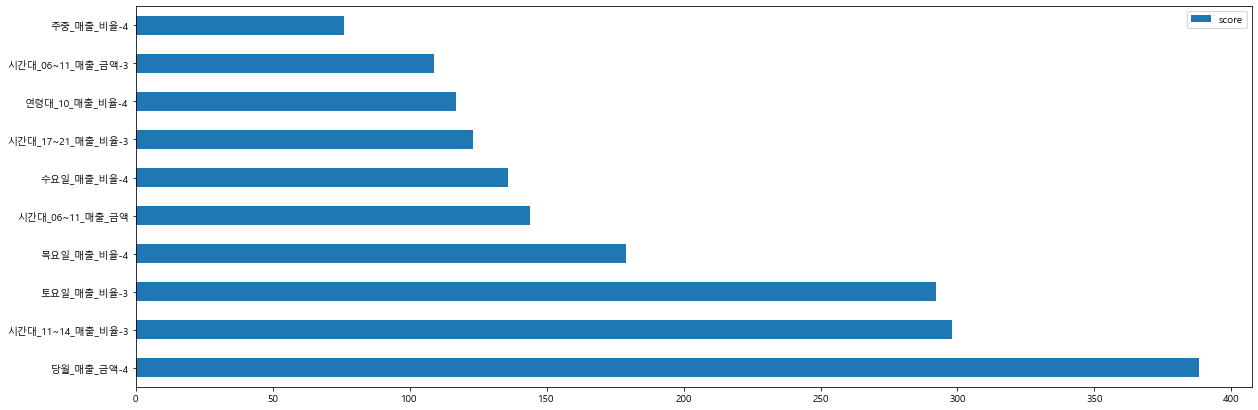

In [177]:
plt.rcParams['font.family'] = 'Malgun Gothic'
feature_important = model.get_booster().get_score(importance_type='weight')
keys = list(feature_important.keys())
values = list(feature_important.values())
plt.rcParams["figure.figsize"] = (20,7)
data_50 = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
data_50[:10].plot(kind='barh')

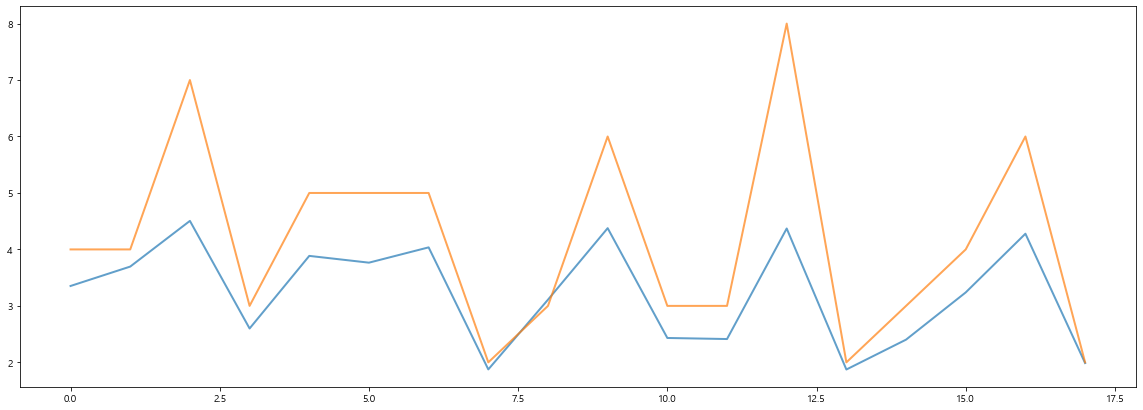

In [181]:
plt.pyplot.plot(model.predict(x_in),alpha = 0.7,linewidth = 2)
# 파란색 : 예측값
# 주황색 : 실제값
# 갈색 : 파란색과 주황색이 겹치는 부분
plt.pyplot.plot(x_out.values,alpha = 0.7,linewidth = 2)